# 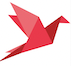 
# Sentiment analysis on private IMDB reviews with Sarus



### In this tutorial for **Data Practitioners**, you will see how to:

1. Connect to Sarus gateway and see available datasets
2. Analyze the private data as a pandas dataframe
3. Submit SQL queries 
4. Preprocess the remote private data
4. Train a TF text classification model onto the remote real data


# Data source

**Extract of 5k rows of IMDB movie reviews** to build a sentiment analysis model:  
https://www.kaggle.com/lakshmi25npathi/imdb_extract-dataset-of-50k-movie-reviews

# 1. Connect to Sarus gateway & explore the list of available datasets

In [1]:
%%capture
!pip install sarus

In [2]:
import pandas as pd
import tensorflow as tf

from sarus import Client
from sarus.tensorflow import Model

from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
client = Client(url='https://demo.sarus.tech:5000', email='demo.user@sarus.tech', password='Demo1')
# Here, you can use our demo credentials or your own ones!

In [4]:
client.list_datasets()

[<Sarus Dataset slugname=imdb_reviews id=15>,
 <Sarus Dataset slugname=patient_data id=14>,
 <Sarus Dataset slugname=private_census id=13>]

In [5]:
remote_dataset = client.dataset(slugname='imdb_reviews')

# 2. Explore private dataset 

In [6]:
dataframe = remote_dataset.as_pandas()
dataframe.head(5) # Falls back to synthetic data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
dataframe.review[13]

"The cast played Shakespeare.<br /><br />Shakespeare lost.<br /><br />I appreciate that this is trying to bring Shakespeare to the masses, but why ruin something so good.<br /><br />Is it because 'The Scottish Play' is my favorite Shakespeare? I do not know. What I do know is that a certain Rev Bowdler (hence bowdlerization) tried to do something similar in the Victorian era.<br /><br />In other words, you cannot improve perfection.<br /><br />I have no more to write but as I have to write at least ten lines of text (and English composition was never my forte I will just have to keep going and say that this movie, as the saying goes, just does not cut it."

In [8]:
r = client.query('SELECT COUNT(*) AS dp_total FROM imdb_reviews', target_epsilon=0.5)
pd.DataFrame(r['result'], columns=r['columns'])

,dp_total
0,5004.789199


In [9]:
r = client.query('SELECT sentiment, COUNT(*) AS dp_total FROM imdb_reviews GROUP BY sentiment', target_epsilon=0.5) 
pd.DataFrame(r['result'], columns=r['columns'])

,sentiment,dp_total
0,negative,2545.123480
1,positive,2464.239508


# 3. Build a TensorFlow model with Differential Privacy

We define a preprocessing function to:
- vectorize text data remotely: convert text into numerical representation based on a predefined vocabulary: **we use the vocabulary of the synthetic data**
- create a (X,y) tuple (y = target variable to predict)

In [10]:
import re
import string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Retrieving the vocabulary of synthetic data to build the Text vectorization layer
sds_review = tf.data.Dataset.from_tensor_slices(dataframe.review) 

max_features = 1000 # Max number of words used from vocabulary. Can be tuned
sequence_length = 250 # Output vector size. Can be tuned

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorize_layer.adapt(sds_review)

vocab_data = vectorize_layer.get_vocabulary()

print(vocab_data)

['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but', 'film', 'on', 'you', 'not', 'are', 'his', 'have', 'be', 'one', 'he', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'just', 'or', 'about', 'if', 'her', 'out', 'has', 'what', 'some', 'there', 'good', 'when', 'very', 'more', 'even', 'would', 'up', 'no', 'my', 'which', 'she', 'their', 'see', 'time', 'story', 'really', 'were', 'had', 'only', 'can', 'me', 'well', 'much', 'been', 'than', 'because', 'we', 'get', 'into', 'bad', 'will', 'do', 'other', 'first', 'also', 'how', 'people', 'great', 'most', 'dont', 'him', 'movies', 'make', 'way', 'made', 'then', 'any', 'them', 'too', 'films', 'after', 'could', 'characters', 'being', 'watch', 'think', 'never', 'little', 'many', 'character', 'seen', 'plot', 'two', 'where', 'know', 'acting', 'best', 'your', 'did', 'love', 'ever', 'show', 'life', 'does', 'off', 'scene', 'better', 'still', 'say', 'thes

In [11]:
# Preprocessing function

def preprocess(row):
  return row['review'][:,None], row['sentiment']#[:,None]

# We apply it remotely to the original dataset
tf_sds = remote_dataset.as_tensorflow().batch(1000).map(preprocess)

In [12]:
# Model definition function

embedding_dim = 16

class DNN(Model):
  def __init__(self):
    super(DNN, self).__init__()
    self.vectorize = TextVectorization(
        standardize='lower_and_strip_punctuation',
        output_mode='int',
        output_sequence_length=sequence_length,
        vocabulary=vocab_data,
    )
    self.layer_list = [
        Embedding(input_dim=max_features, output_dim=embedding_dim),
        GlobalAveragePooling1D(),
        Dense(1)
    ]

  def call(self, x):
    x = self.vectorize(x)
    for layer in self.layer_list: 
      x = layer(x)
    return x

model = DNN()
loss = BinaryCrossentropy(from_logits=True)
model.compile(
    optimizer=Adam(learning_rate=200),
    loss=loss,
    metrics=tf.metrics.BinaryAccuracy(threshold=0),
)

In [13]:
model.fit(tf_sds, epochs=2, target_epsilon=1)  

Epoch 1/2
5/5 [==============================] - 3s 100ms/step - loss: 0.6931 - binary_accuracy: 0.4994
Epoch 2/2
5/5 [==============================] - 1s 95ms/step - loss: 0.6929 - binary_accuracy: 0.5122



In [14]:
print(model.summary())

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe multiple                  0         
_________________________________________________________________
embedding (Embedding)        multiple                  16000     
_________________________________________________________________
global_average_pooling1d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  17        
Total params: 16,017
Trainable params: 16,017
Non-trainable params: 0
_________________________________________________________________
None
